<a href="https://colab.research.google.com/github/Samin-Sadaf7/NN_works/blob/main/Makemore_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-02 09:14:27--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-07-02 09:14:27 (6.06 MB/s) - ‘names.txt’ saved [228145/228145]



In [92]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [93]:
len(words)

32033

In [94]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [95]:
block_size = 3
X = []
Y = []
for w in words:
  context = [0] * block_size
  #print(w)
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
    #print(''.join(itos[i] for i in context), '---->', itos[ix])

X = torch.tensor(X)
Y = torch.tensor(Y)

In [96]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [97]:
C= torch.randn((27,2))

In [98]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [99]:
W1= torch.randn((6,100))
b1= torch.randn(100)

In [100]:
torch.cat(torch.unbind(emb, dim=1),1).shape

torch.Size([228146, 6])

In [101]:
emb.view((228146,6)) # same as  previous cell but more more memory efficient

tensor([[-2.1147,  1.1590, -2.1147,  1.1590, -2.1147,  1.1590],
        [-2.1147,  1.1590, -2.1147,  1.1590,  0.2499,  0.5845],
        [-2.1147,  1.1590,  0.2499,  0.5845, -1.6648, -0.0867],
        ...,
        [ 0.2688, -1.6213,  0.2688, -1.6213, -0.5562, -1.9199],
        [ 0.2688, -1.6213, -0.5562, -1.9199,  0.2688, -1.6213],
        [-0.5562, -1.9199,  0.2688, -1.6213, -0.4367, -0.5759]])

In [102]:
h= torch.tanh(emb.view(-1, 6) @ W1 +  b1) # hidden layer

In [103]:
h.shape

torch.Size([228146, 100])

Note: b1 will be broadcasted

Rules of broadcast:

1.   Align right
2.   Assign a fake dimension
3.   Copy vertically to sum it up for b

W1 = 32, 100
b1 = 100
now, b1 = 1, 100
copy vertically and sum to get 32, 100 of h


In [104]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [105]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [106]:
counts = logits.exp()

In [107]:
probs=  counts/counts.sum(1, keepdims=True)

In [108]:
loss = - probs[torch.arange(X.shape[0]), Y].log().mean()

In [109]:
loss

tensor(15.7181)

In [110]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [111]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [112]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(19.5052)

In [113]:
F.cross_entropy(logits, Y)#Cross entropy makes forward pass more efficient and backward pass more efficient
# Also , it takes the max of all the logits values and minus it to total to avoid nan or inf issues

tensor(19.5052)

In [114]:
for p in parameters:
  p.requires_grad = True

In [115]:
#Implementing Learning rate decay
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [127]:
#lri = []
#lossi = []
#implemented with minibatch
#Minibatch gradient is not as smooth as usual gradient
for i in range(100000):
  #minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  #forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #Update using learing rate decay
  #lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #lri.append(lre[i])
  #lossi.append(loss.item())
print(loss.item())

1.9256051778793335


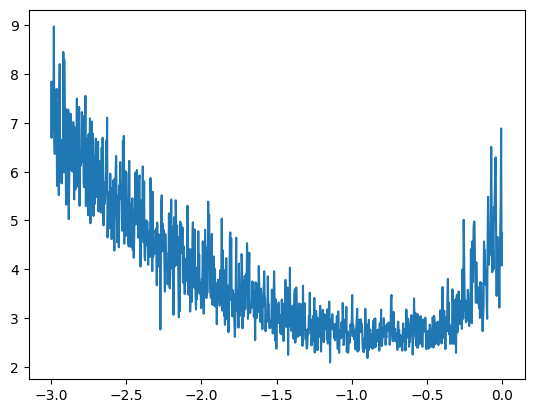

In [122]:
#plt.plot(lri, lossi)

0.1 is a good learning rate


In [87]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [128]:
#Need to split the dataset into training , dev and test set
# 80, 10, 10
# Optimize the parameters
# otherwise we will overfit the model

In [129]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
     # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [130]:
C= torch.randn((27,2))

In [131]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [180]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [181]:
sum(p.nelement() for p in parameters) # number of parameters in total

18167

In [182]:
for p in parameters:
  p.requires_grad = True

In [183]:
lri = []
lossi = []
stepi = []

In [184]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [186]:
print(loss.item())

1.9766548871994019


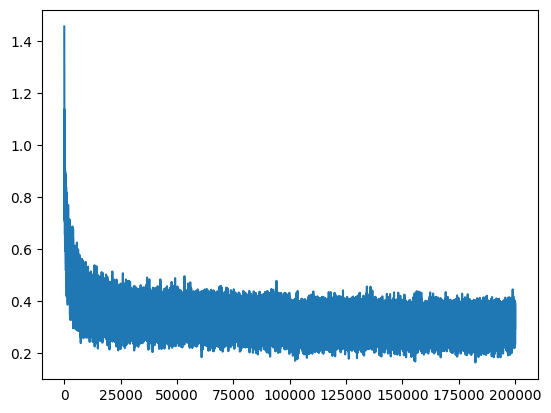

In [185]:
plt.plot(stepi, lossi)

In [188]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0562, grad_fn=<NllLossBackward0>)

In [189]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1441, grad_fn=<NllLossBackward0>)

In [190]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1415, grad_fn=<NllLossBackward0>)

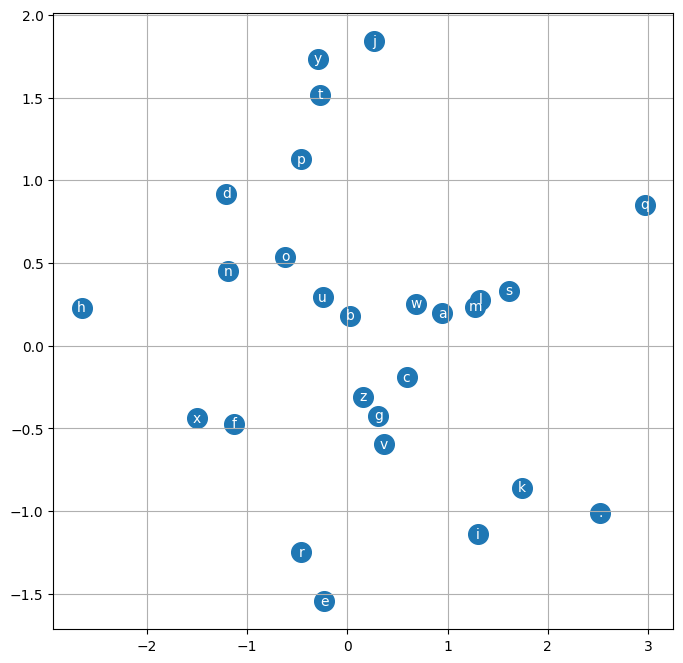

In [191]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [192]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montalmyah.
see.
mel.
ryla.
remmadiendra.
gradee.
daeliah.
miloparekensley.
aarselyzion.
kalin.
shub.
rishira.
sten.
joselynn.
novana.
ubented.
ryy.
juliel.
yuva.
myskeyla.
